## Библиотеки. Данные. Классы алгоритмов

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import pandas as pd
from sklearn import datasets

In [29]:
# Генерация данных для задачи классификации
# X, y = datasets.make_classification(n_samples=100, n_features=5, n_informative=3, n_classes=2)

# Генерация данных для задачи регрессии
X, y = datasets.make_regression(n_samples=100, n_features=10, n_informative=5)

In [30]:
def plot_results(vmin=0, vmax=1, initial_score=0):
    print("Best chromosome:\n", ga.best_genes,
      "\n\nwith score: ", ga.score, " at population # ", ga.at_iteration)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
#     fig.subplots_adjust(wspace=0)

    axes[0].plot(ga.cv_all_scores, label="chromosomes score")

    axes[0].plot([0, len(ga.cv_all_scores)], [1, 1], c="k")
    axes[0].set_ylabel('cv score')
    axes[0].set_xlabel('chromosomes')

    axes[1].plot(ga.cv_best_score, label="best cv score")
    axes[1].set_ylabel('cv score')
    axes[1].plot([0, len(ga.cv_best_score) - 1], [1, 1], c="k")
    axes[1].plot([0, len(ga.cv_best_score) - 1], [initial_score, initial_score], c="r", label="initial cv score")
    axes[1].set_xlabel('populations')

    axes[0].set_ylim(vmin, vmax)
    axes[1].set_ylim(vmin, vmax)
    plt.legend(loc='lower right')
    plt.show()

In [31]:
def importance():
    columns = ["x" + str(i) for i in range(X.shape[1])]

    importance = pd.DataFrame(np.array(ga.gene_expression / len(ga.cv_best_score) * 100, 
                              dtype=np.int64),
                              columns=columns, index=manipulations)
    return importance

In [32]:
class KNN:
    def __init__(self, k=3, scale=True):
        self.scale = scale
        self.k = k
        self.method = "classification"
        self.metric = "accuracy"
        self.score_list = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
        if (y_train == y_train.astype(int)).sum() != len(y_train):
            self.method = "regression"
            self.metric = "r2"
        
    def predict(self, X_test):
        labels = [self.find_labels(x_test) for x_test in X_test]
        return np.array(labels)
    
    def find_labels(self, x_test):
        distances = [self.distance(x_test, x_train) for x_train in self.X_train]   
        k_nearest = np.argsort(distances)[:self.k]
        y_labels = [self.y_train[i] for i in k_nearest]
        
        if self.method == "regression":
            return sum(y_labels) / self.k
            
        return self.most_common(y_labels)
        
    def most_common(self, y_labels):
        a = tuple(set(y_labels))
        count = [y_labels.count(i) for i in a]
        return a[np.argsort(count)[-1]]
    
    def score(self, y_predicted, y_train):
        if self.method == "regression":
            return "r2", 1 - np.sum((y_predicted - y_train)**2) / np.sum((y_train.mean() - y_train)**2)
            
        return "accuracy", (y_predicted == y_train).sum() / len(y_train)

    def distance(self, x_test, x_train):
        return np.sqrt(np.abs(np.sum((x_test - x_train)**2)))
    
    def cv(self, X, y, cv=5):
        if X.shape[0] == 0:
            return self.metric, np.array([0] * cv)
        
        self.X = X
        self.y = np.reshape(y, (len(y), 1))        
        data = np.concatenate((self.X, self.y), axis=1)
        np.random.shuffle(data)
         
        data = pd.DataFrame(data)
        self.score_list = []
        
        for i in range(cv):
            lenght = int(len(y) / cv)
            
            end = i * lenght + lenght
            
            if i == cv - 1: 
                end = -1
            
            X_test = data.iloc[i * lenght: end, :-1]
            X_train = data.drop(index=X_test.index).iloc[:, :-1]
            
            if self.scale:
                for j in range(X_train.shape[1]):
                    mean = X_train.iloc[:, j].mean()
                    std = X_train.iloc[:, j].std()

                    X_train.iloc[:, j] = (X_train.iloc[:, j] - mean) / std
                    X_test.iloc[:, j] = (X_test.iloc[:, j] - mean) / std
            
            y_test = data.iloc[i * lenght: end, -1]
            y_train = data.drop(index=X_test.index).iloc[:, -1]
            
            clf = KNN()
            clf.fit(np.array(X_train), np.array(y_train))
            self.metric, s_ = clf.score(clf.predict(np.array(X_test)), np.array(y_test))
            self.score_list.append(s_)  

        return self.metric, np.array(self.score_list)

In [33]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [34]:
class DecisionTree:
    def __init__(self, max_depth=100, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
        self.method = "classification"
    
    def fit(self, X, y):
        if (y == y.astype(int)).sum() != len(y):
            self.method = "regression"
            
        self.tree = self.grow_tree(X, y)
        
    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])
    
    def entropy(self, y):
        if self.method == "classification":
            hist = np.bincount(y)
            ps = hist / len(y)
            return -np.sum([p * np.log2(p) for p in ps if p > 0])
        
        c = np.sum(y) / len(y)
        return np.sum((c - y)**2) / len(y)
    
    def most_common(self, y):
        if self.method == "classification":
            labels = np.unique(y)
            count = [list(y).count(i) for i in labels]
            return labels[np.argmax(count)]
        
        c = np.sum(y) / len(y)
        return c
    
    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        best_gain = -1
        
        index = np.random.choice(X.shape[1])
        
        for i in [index]:
            thresholds = np.unique(X[:, i])
            for threshold in thresholds:
                gain = self.information_gain(X[:, i], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = i
                    best_threshold = threshold
        return best_feature, best_threshold
    
    def information_gain(self, X_column, y, threshold):
        if self.method == "classification" and len(np.unique(y)) == 1:
            return 0
        
        n = len(y)
        parent = self.entropy(y)
        
        left_indexes = np.argwhere(X_column <= threshold).flatten()
        right_indexes = np.argwhere(X_column > threshold).flatten()

        if self.method == "regression" and (len(left_indexes) == 0 or len(right_indexes) == 0):
            return 0
        
        e_l, n_l = self.entropy(y[left_indexes]), len(y[left_indexes])
        e_r, n_r = self.entropy(y[right_indexes]), len(y[right_indexes])
        
        child = (n_l / n) * e_l + (n_r / n) * e_r
        return parent - child
    
    def grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        if n_samples <= self.min_samples or n_labels == 1 or depth >= self.max_depth:
            return Node(value=self.most_common(y))
        
        best_feature, best_threshold = self.best_split(X, y)
        
        left_indexes = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_indexes = np.argwhere(X[:, best_feature] > best_threshold).flatten()
        
        left = self.grow_tree(X[left_indexes, :], y[left_indexes], depth + 1)
        right = self.grow_tree(X[right_indexes, :], y[right_indexes], depth + 1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        if x[tree.feature] <= tree.threshold:
            return self.travers_tree(x, tree.left)
        return self.travers_tree(x, tree.right)

In [35]:
class RandomForest:
    def __init__(self, max_depth=20, min_samples=10, n_trees=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.n_trees = n_trees
        self.samples = []
        self.oob_samples = []
        self.trees = []
        self.predicted = []
        self.n_samples = None
        self.method = "classification"
        self.metric = "accuracy"
        self.score_list = []
        
    def fit(self, X, y):
        if (y == y.astype(int)).sum() != len(y):
            self.method = "regression"
            self.metric = "r2"
            
        self.n_samples = X.shape[0]
        
        for i in range(self.n_trees):
            samples = np.random.choice(self.n_samples, self.n_samples, replace=True)
            oob_samples = np.array([j for j in range(self.n_samples) if j not in samples])
            
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples=self.min_samples)
            tree.fit(X[samples, :], y[samples])
            
            self.samples.append(samples)
            self.oob_samples.append(oob_samples)
            self.trees.append(tree)
    
    def predict(self, X):
        predictions = []
        for i in range(self.n_trees):
            predictions.append(self.trees[i].predict(X))
        
        predictions = [self.trees[0].most_common(np.array(predictions)[:, i]) for i in range(X.shape[0])]
        
        return predictions
        
    def score(self, predicted, y):
        if self.method == "regression":
            return "r2", 1 - np.sum((predicted - y)**2) / np.sum((y.mean() - y)**2)
            
        return "accuracy", (predicted == y).sum() / len(y)
    
    def cv(self, X, y, cv=5):
        if X.shape[0] == 0:
            return self.metric, np.array([0] * cv)
        
        self.X = X
        self.y = np.reshape(y, (len(y), 1))        
        data = np.concatenate((self.X, self.y), axis=1)
        np.random.shuffle(data)
         
        data = pd.DataFrame(data)
        self.score_list = []
        
        for i in range(cv):
            lenght = int(len(y) / cv)
            
            end = i * lenght + lenght
            
            if i == cv - 1: 
                end = -1
            
            X_test = data.iloc[i * lenght: end, :-1]
            X_train = data.drop(index=X_test.index).iloc[:, :-1]
            
            y_test = data.iloc[i * lenght: end, -1].astype("int32")
            y_train = data.drop(index=X_test.index).iloc[:, -1].astype("int32")
            
            clf = RandomForest(max_depth=self.max_depth, 
                               min_samples=self.min_samples, 
                               n_trees=self.n_trees)
            
            clf.fit(np.array(X_train), np.array(y_train))
            self.metric, s_ = clf.score(clf.predict(np.array(X_test)), np.array(y_test))
            self.score_list.append(s_)  

        return self.metric, np.array(self.score_list)

In [36]:
class GeneticAlgorithm:
    def __init__(self, X, y, populations=100, chromosomes=10, reverse_best=True, 
                 still_random=2, mutate_genes=0.01, manipulations=None, model=None,
                 desired_score=None):
        self.X = X
        self.y = y
        self.populations = populations
        self.chromosomes = chromosomes
        self.reverse_best = reverse_best
        self.still_random = still_random
        self.mutate_genes = mutate_genes
        self.manipulations = manipulations
        self.desired_score = desired_score
        
        # перевод из долей в количество мутируемых ген
        if mutate_genes < 1.0: 
            self.mutate_genes = np.ceil(self.X.shape[1] * len(self.manipulations) * mutate_genes)

        self.model = model
        self.count = 0
        self.score = 0
        self.cv_best_score = [] # лучшее качество в поколении
        self.best_genes = None  # лучший набор ген
        self.at_iteration = 0   # ...на итерации
        self.cv_all_scores = [] 
        # частота использования манипуляций над признаками (важность)
        self.gene_expression  = np.zeros((len(self.manipulations), self.X.shape[1]))
        
    def generate_population(self):  
        # генерация нулевого поколения, случайное заполнение хромосом
        self.population = []

        for i in range(self.chromosomes):       
            self.population.append(self.random_genes())
        
        sorted_population = self.sort_population(self.population)
        return sorted_population
    
    def random_genes(self):  
        genes = np.random.randint(2, size=(len(self.manipulations), self.X.shape[1]))
        genes = self.correct_manipulations(genes)
        
        # вычисление качества по скользящему контролю для данного набора ген
        cv_score = self.fitness_func(genes)
        individual = {"genes": genes, "cv_score": cv_score}
        return individual

    def sort_population(self, population):
        # сортировка хромосом в популяции по качеству модели
        sorted_population = sorted(population, key=lambda k: k["cv_score"], reverse=True)
        self.cv_best_score.append(sorted_population[0]["cv_score"])
        
        # счётчик (частота) использования манипуляций над признаками по наилучшим хромосомам
        self.gene_expression += sorted_population[0]["genes"]
        self.count += 1
        return sorted_population

    def add_feature(self, X_origin, genes):
        # формирование признаков по заданным в хромосоме манипуляциям
        X_new = []
        for i in range(X_origin.shape[1]): 
            if genes[0, i]: X_new.append(X_origin[:, i])
            if genes[1, i]: X_new.append(X_origin[:, i]**2)
            if genes[2, i] and 0 not in X_origin[:, i]: X_new.append(1 / X_origin[:, i])
#             if genes[3, i]: X_new.append(np.exp(X_origin[:, i]))
            if genes[3, i]: X_new.append(np.sin(X_origin[:, i]))

        X_new = np.array(X_new).T
        return X_new
                                  
    def fitness_func(self, genes):  
        # расчет качества модели по скользящему контролю
        X_new = self.add_feature(self.X, genes)
        cv_score = self.model.cv(X_new, self.y, cv=5)[1]
        cv_score = cv_score.sum() / len(cv_score)
        
        self.cv_all_scores.append(cv_score)
        
        if cv_score > self.score:
            self.score = cv_score
            self.best_genes = genes
            self.at_iteration = self.count

        return (cv_score)
    
    def make_next_population(self, prev_population):
        # создание следующего поколения
        next_population = []       
        next_population.append(prev_population[0])
        
        # скрещивание лучшей хромосомы с худшими
        for i in range (1, self.chromosomes - self.still_random - self.reverse_best, 1):
            best = prev_population[0]
            weaker = prev_population[i]

            individual = self.crossover(best, weaker)
            # мутация некоторых ген
            individual = self.mutate(individual)
            next_population.append(individual)

        # добавление в поколение хромосом со случайным набором ген
        i = 0
        while i < self.still_random:
            next_population.append(self.random_genes())
            i += 1
        
        # последняя хромосома в поколении с реверсом ген лучшей хромосомы
        if self.reverse_best:
            last_individual = (prev_population[0]["genes"] - 1) * (-1)
            last_individual = self.correct_manipulations(last_individual)
            cv_score = self.fitness_func(last_individual)
            next_population.append({"genes": last_individual, "cv_score": cv_score})

        return self.sort_population(next_population)
    
    def crossover(self, best, weaker):
        # метод скрещивания хромосом (50 / 50)
        b = np.array(best["genes"])
        c = np.array(weaker["genes"])

        mask = np.random.randint(0, 2, b.shape, dtype=bool)
        d = np.where(mask, b, c)
        individual = self.correct_manipulations(d)
        
        return {"genes": individual, "cv_score": np.nan}

    def correct_manipulations(self, genes):
        # контроль доступных манипуляций над признаками
        for ind, val in enumerate(self.manipulations):
            genes[ind, :] = genes[ind, :] * int(val)
        return genes

    def mutate(self, individual):
        # метод для мутации ген
        mutate = np.array(individual["genes"])

        cnt = 0    
        a = []

        while cnt < self.mutate_genes:
            i = np.random.randint(mutate.shape[0])        
            j = np.random.randint(mutate.shape[1])

            if [i, j] not in a and bool(int(self.manipulations[i])):

                if mutate[i, j]: mutate[i, j] = 0
                else: mutate[i, j] = 1

                cnt += 1
                a += [i, j]
        
        mutate = self.correct_manipulations(mutate)
        cv_score = self.fitness_func(mutate) 
        return {"genes": mutate, "cv_score": cv_score}

## Поиск информативных признаков и манипуляций над признаками.

### Инициализация модели KNN.

In [41]:
# Качество по кросс валидации на неизмененных данных
model = KNN(k=3, scale=True)
initial_score = model.cv(X, y, cv=5)[1].sum() / 5
initial_score

0.6916559260089448

### Инициализация модели Random Forest

In [ ]:
# Качество по кросс валидации на неизмененных данных
model = RandomForest(max_depth=50, 
                     min_samples=5, 
                     n_trees=20)

initial_score = model.cv(X, y, cv=5)[1].sum() / 5
initial_score

### Поиск информативных признаков

In [42]:
manipulations = ["x", "x2", "1/x", "sin(x)"]# допустимые манипуляции над признаками
    
ga = GeneticAlgorithm(X, y,                 # передаем признаки и целевую переменную
                      populations=100,       # сколько поколений создать (число итераци)
                      chromosomes=10,       # число хромосом в одном поколении
                      reverse_best=False,   # реверсировать хромосому с лучшей моделью?
                      still_random=1,       # сколько хромосом генерировать случайным заполнением
                      mutate_genes=0.01,    # доля ген для мутации
                      manipulations="1000", # какие манипуляции над признаками пробовать
                      model=model,          # модель
                      desired_score=None)   # желаемое качество

# создание нулевого поколения
population = ga.generate_population()

for i in tqdm.tqdm(range(ga.populations)):
    # следующее поколение (скрещивание, мутации)
    population = ga.make_next_population(population)
    
    if ga.desired_score is not None and ga.desired_score >= ga.score:
        break
    
print("*** DONE ***")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:43<00:00,  4.03s/it]

*** DONE ***


Best chromosome:
 [[0 0 0 0 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]] 

with score:  0.878929403689469  at population #  26


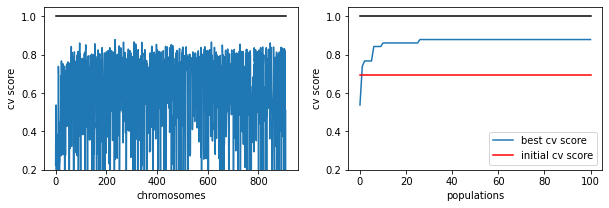

In [46]:
plot_results(vmin=0.2, vmax=1.05, initial_score=initial_score)

In [47]:
# Часто используемые признаки и манипуляции
importance()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
x,4,3,0,1,100,100,99,99,9,3
x2,0,0,0,0,0,0,0,0,0,0
1/x,0,0,0,0,0,0,0,0,0,0
sin(x),0,0,0,0,0,0,0,0,0,0


### Поиск информативных манипуляций над признаками. Горячий рестарт. 

In [48]:
manipulations # допустимые манипуляции над признаками

['x', 'x2', '1/x', 'sin(x)']

In [49]:
hot_restart = True

if hot_restart:
    ga.populations = 100       # сколько еще поколений создать
    ga.manipulations = "1111" # какие манипуляции над признаками пробовать
    ga.mutate_genes = 0.01    # доля ген для мутации
    ga.reverse_best = True    # реверсировать хромосому с лучшей моделью?
    ga.still_random = 1       # сколько хромосом генерировать случайным заполнением

    for i in tqdm.tqdm(range(ga.populations)):
        # следующее поколение (скрещивание, мутации)
        population = ga.make_next_population(population)

    print("*** DONE ***")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:35<00:00,  5.15s/it]

*** DONE ***


Best chromosome:
 [[0 0 0 0 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]] 

with score:  0.8796909124904035  at population #  144


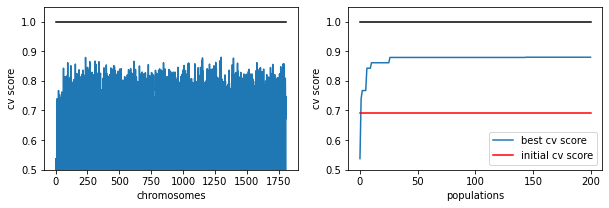

In [50]:
plot_results(vmin=0.5, vmax=1.05, initial_score=initial_score)

In [51]:
# Часто используемые признаки и манипуляции
importance()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
x,2,1,0,0,100,100,99,99,4,1
x2,0,0,0,0,0,0,0,0,0,0
1/x,0,0,0,0,0,0,0,0,0,0
sin(x),0,0,0,0,28,0,0,0,0,0
